# Tutorial for Wasserstein Wormhole

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import umap
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns


import sklearn.metrics
import sklearn.neural_network
import sklearn.neighbors
import skimage.filters

/home/havivd/miniconda3/envs/WormholeUpdate/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-25 16:24:37.098371: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 16:24:37.148586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 16:24:48.467709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [3]:
from wassersteinwormhole import Wormhole

2024-04-25 16:25:16.095512: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Load MNIST data

In [4]:
import tensorflow.keras.datasets
mnist = tensorflow.keras.datasets.mnist

(image_train, label_train), (image_test, label_test) = mnist.load_data()




In [5]:
pc_train, weight_train = [np.stack(np.where(image>0), axis = 1) for image in image_train], [image[image>0]/image[image>0].sum() for image in image_train]
pc_test, weight_test = [np.stack(np.where(image>0), axis = 1) for image in image_test], [image[image>0]/image[image>0].sum() for image in image_test]


### Show some examples

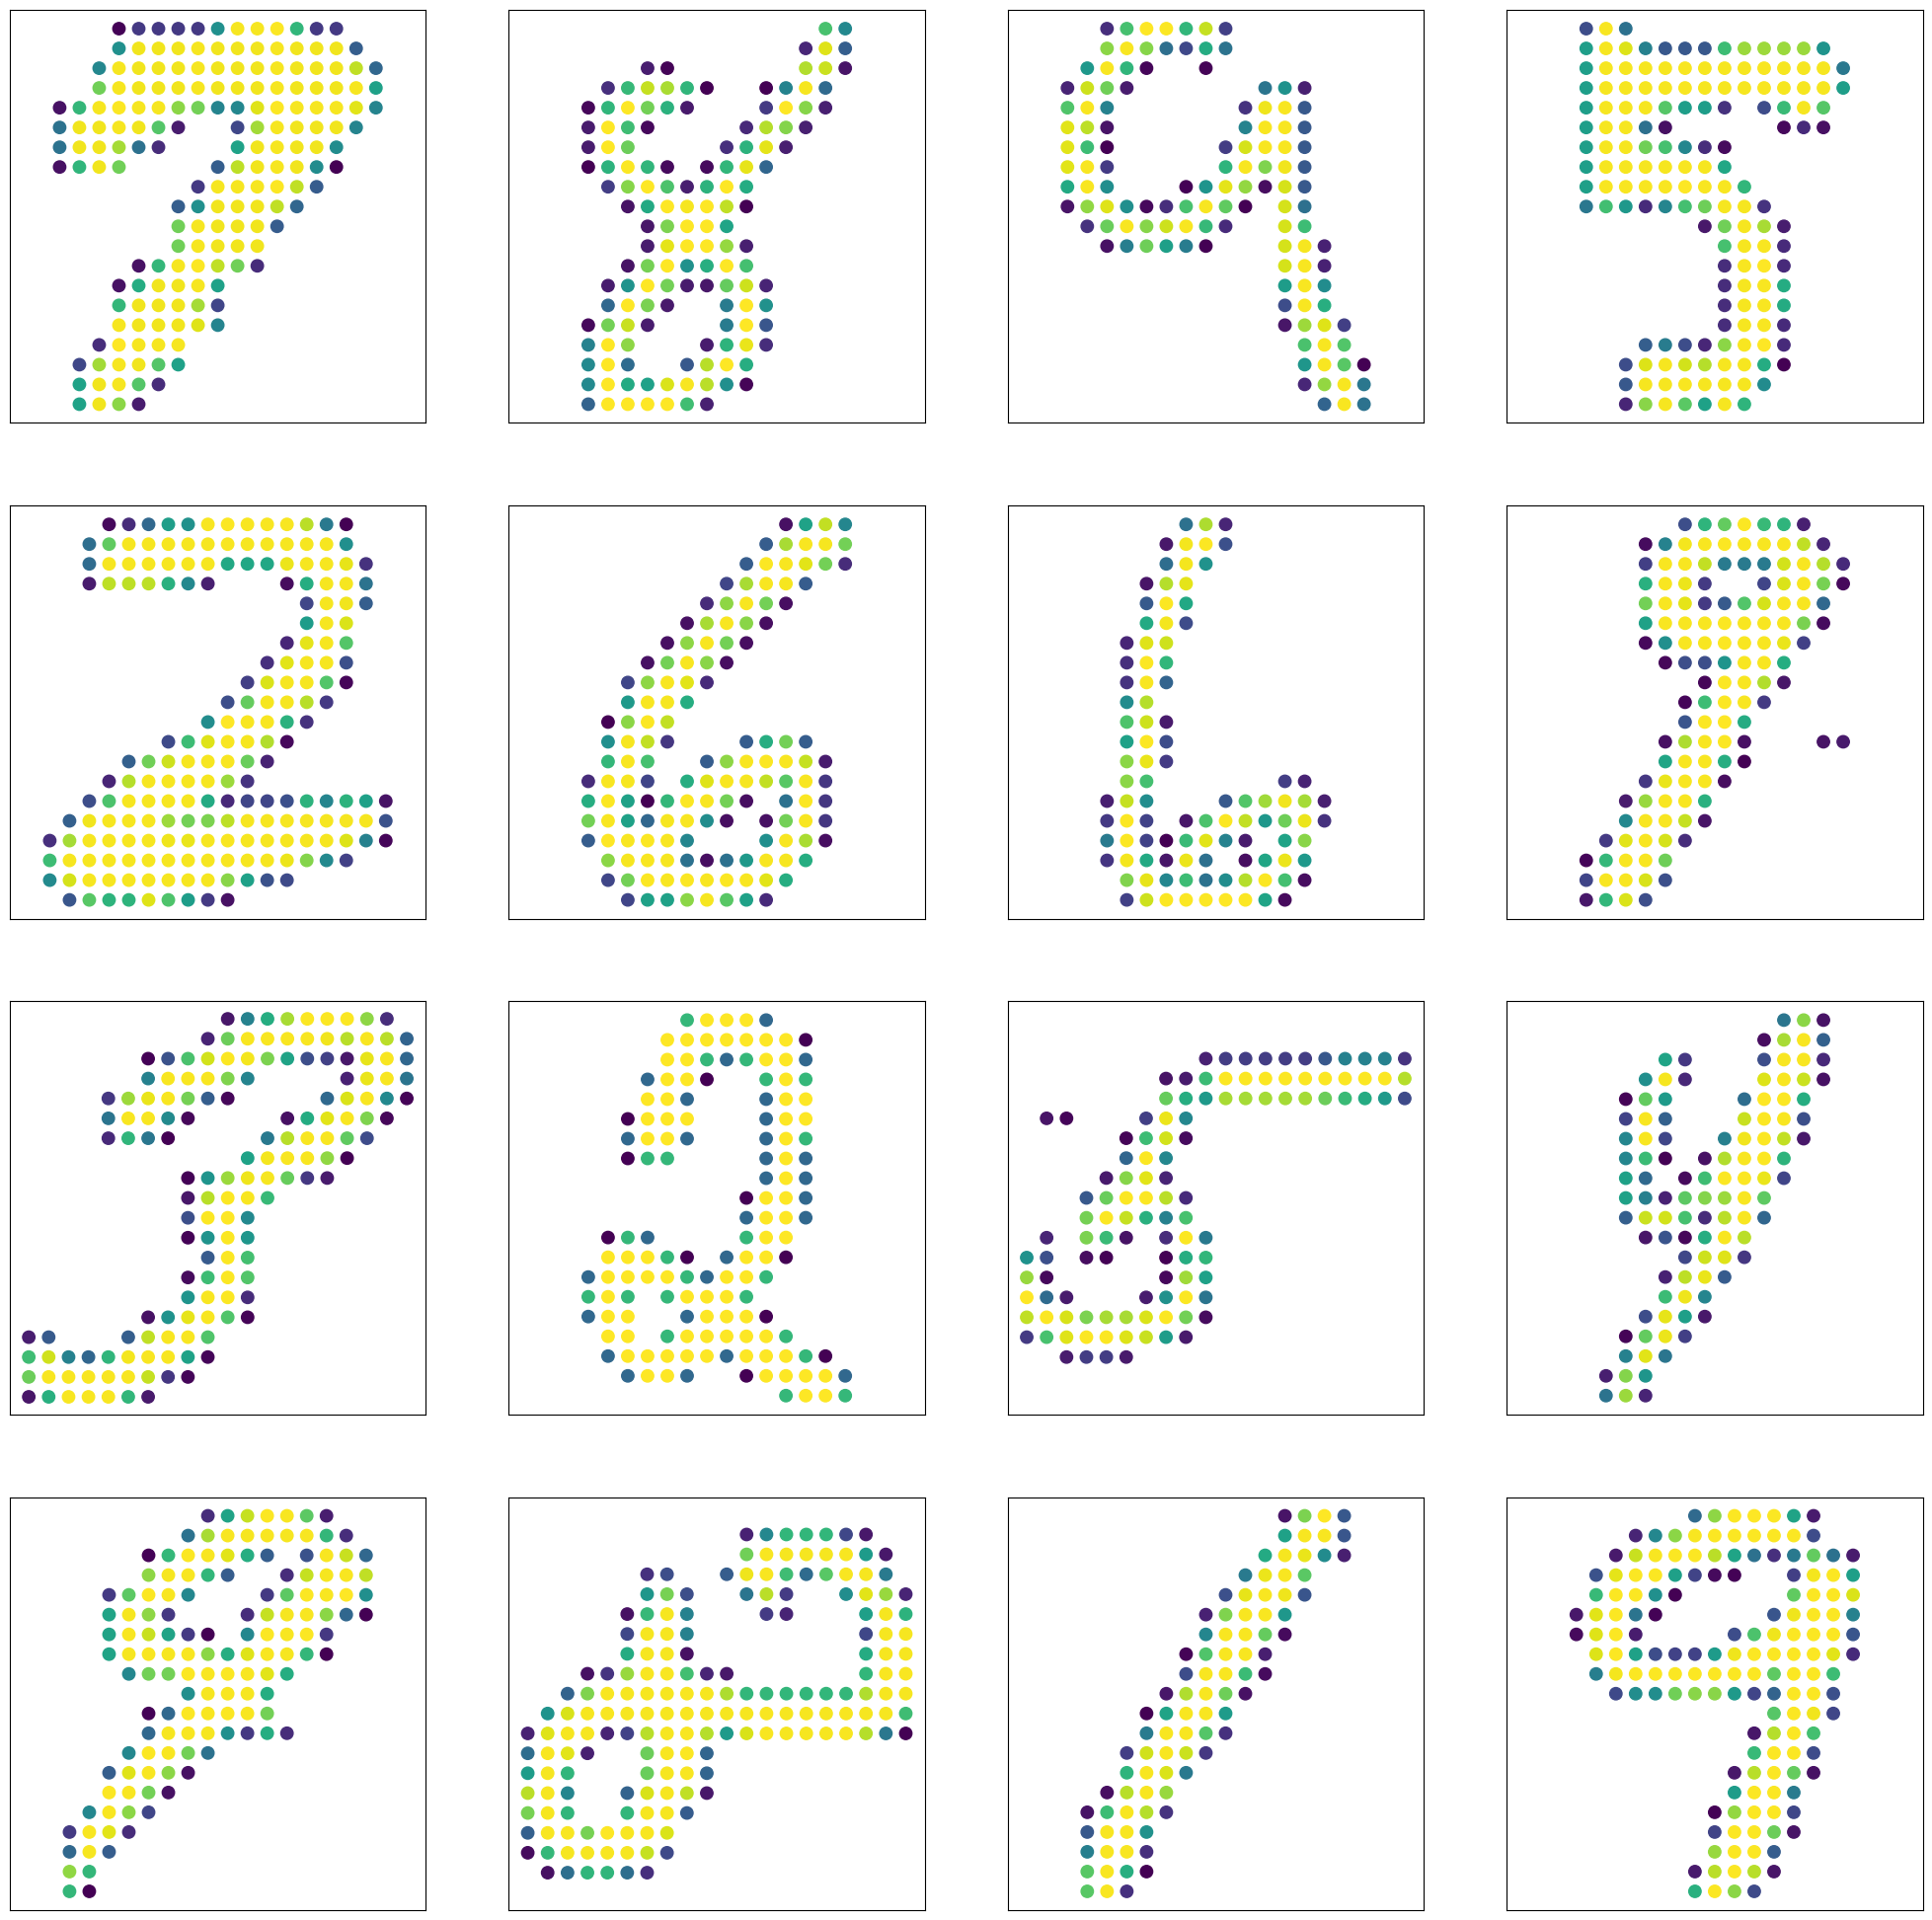

In [6]:
thresh = skimage.filters.threshold_otsu(image_train.reshape([-1]))
fig = plt.figure(figsize = (25,25))
for _ in range(16):
    i = np.random.choice(np.arange(image_train.shape[0]))
    
    plt.subplot(4,4,1+_)
    plt.scatter(pc_train[i][:, 1], -pc_train[i][:, 0], c = weight_train[i], s = 80)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Or load your own set of point-clouds

In [7]:
import pickle

with open('/path/to/data/pc_train.pickle', 'rb') as f:
    pc_train = pickle.load(f)

with open('/path/to/data/weight_train.pickle', 'rb') as f:
    weight_train = pickle.load(f)
    
with open('/path/to/data/pc_test.pickle', 'rb') as f:
    pc_test = pickle.load(f)
    
with open('/path/to/data/weight_test.pickle', 'rb') as f:
    weight_test = pickle.load(f)
    
label_train = np.load('/path/to/data/label_train.npy')
label_test = np.load('/path/to/data/label_test.npy')

## Wormhole Model

In [8]:
WormholeModel = Wormhole(point_clouds = pc_train, weights = weight_train, point_clouds_test = pc_test, weights_test = weight_test)

Using Calculated Min Max Scaling Values


### Train model

In [9]:
WormholeModel.train()

 enc_loss: 2.434e-05 dec_loss: 6.003e-04 enc_corr: 0.986: 100%|██████████| 10000/10000 [06:48<00:00, 24.48it/s]


#### Save parameters

In [10]:
with open('/path/to/savedmodel/WormholeModel.pickle', 'wb') as f:
    pickle.dump(WormholeModel.params, f)

### Or Load trained model

In [11]:
with open('/path/to/savedmodel/WormholeModel.pickle',, 'rb') as f:
    WormholeModel.params = pickle.load(f)

## Generate encodings

In [12]:
train_encodings = WormholeModel.encode(WormholeModel.point_clouds, WormholeModel.weights)
test_encodings = WormholeModel.encode(WormholeModel.point_clouds_test, WormholeModel.weights_test)

### Compare to true Wasserstein distance

#### Train

In [15]:
train_rand_ind = np.random.choice(np.arange(train_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(train_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.weights[train_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.weights[train_rand_ind][upper_traingular_ind[:, 1]]], 
                                                 WormholeModel.eps_enc, WormholeModel.lse_enc)) 

enc_L2 = np.mean(np.square(train_encodings[train_rand_ind][upper_traingular_ind[:, 0]] - train_encodings[train_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

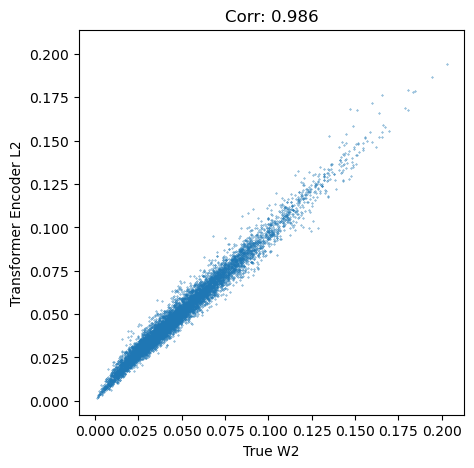

In [16]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

#### Test

In [17]:
test_rand_ind = np.random.choice(np.arange(test_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(test_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.weights_test[test_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.weights_test[test_rand_ind][upper_traingular_ind[:, 1]]], 
                                                 WormholeModel.eps_enc, WormholeModel.lse_enc)) 

enc_L2 = np.mean(np.square(test_encodings[test_rand_ind][upper_traingular_ind[:, 0]] - test_encodings[test_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

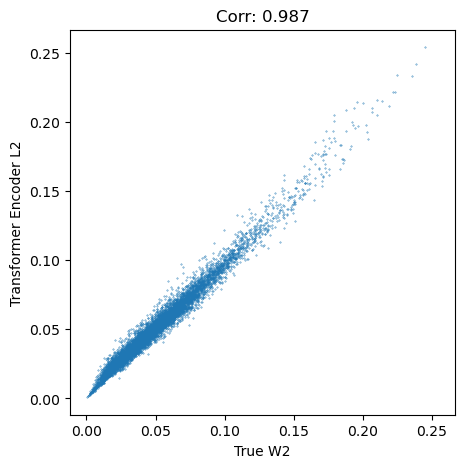

In [18]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

##  Decodings

In [19]:
train_decodings = WormholeModel.decode(train_encodings)
test_decodings = WormholeModel.decode(test_encodings)

### Plot train

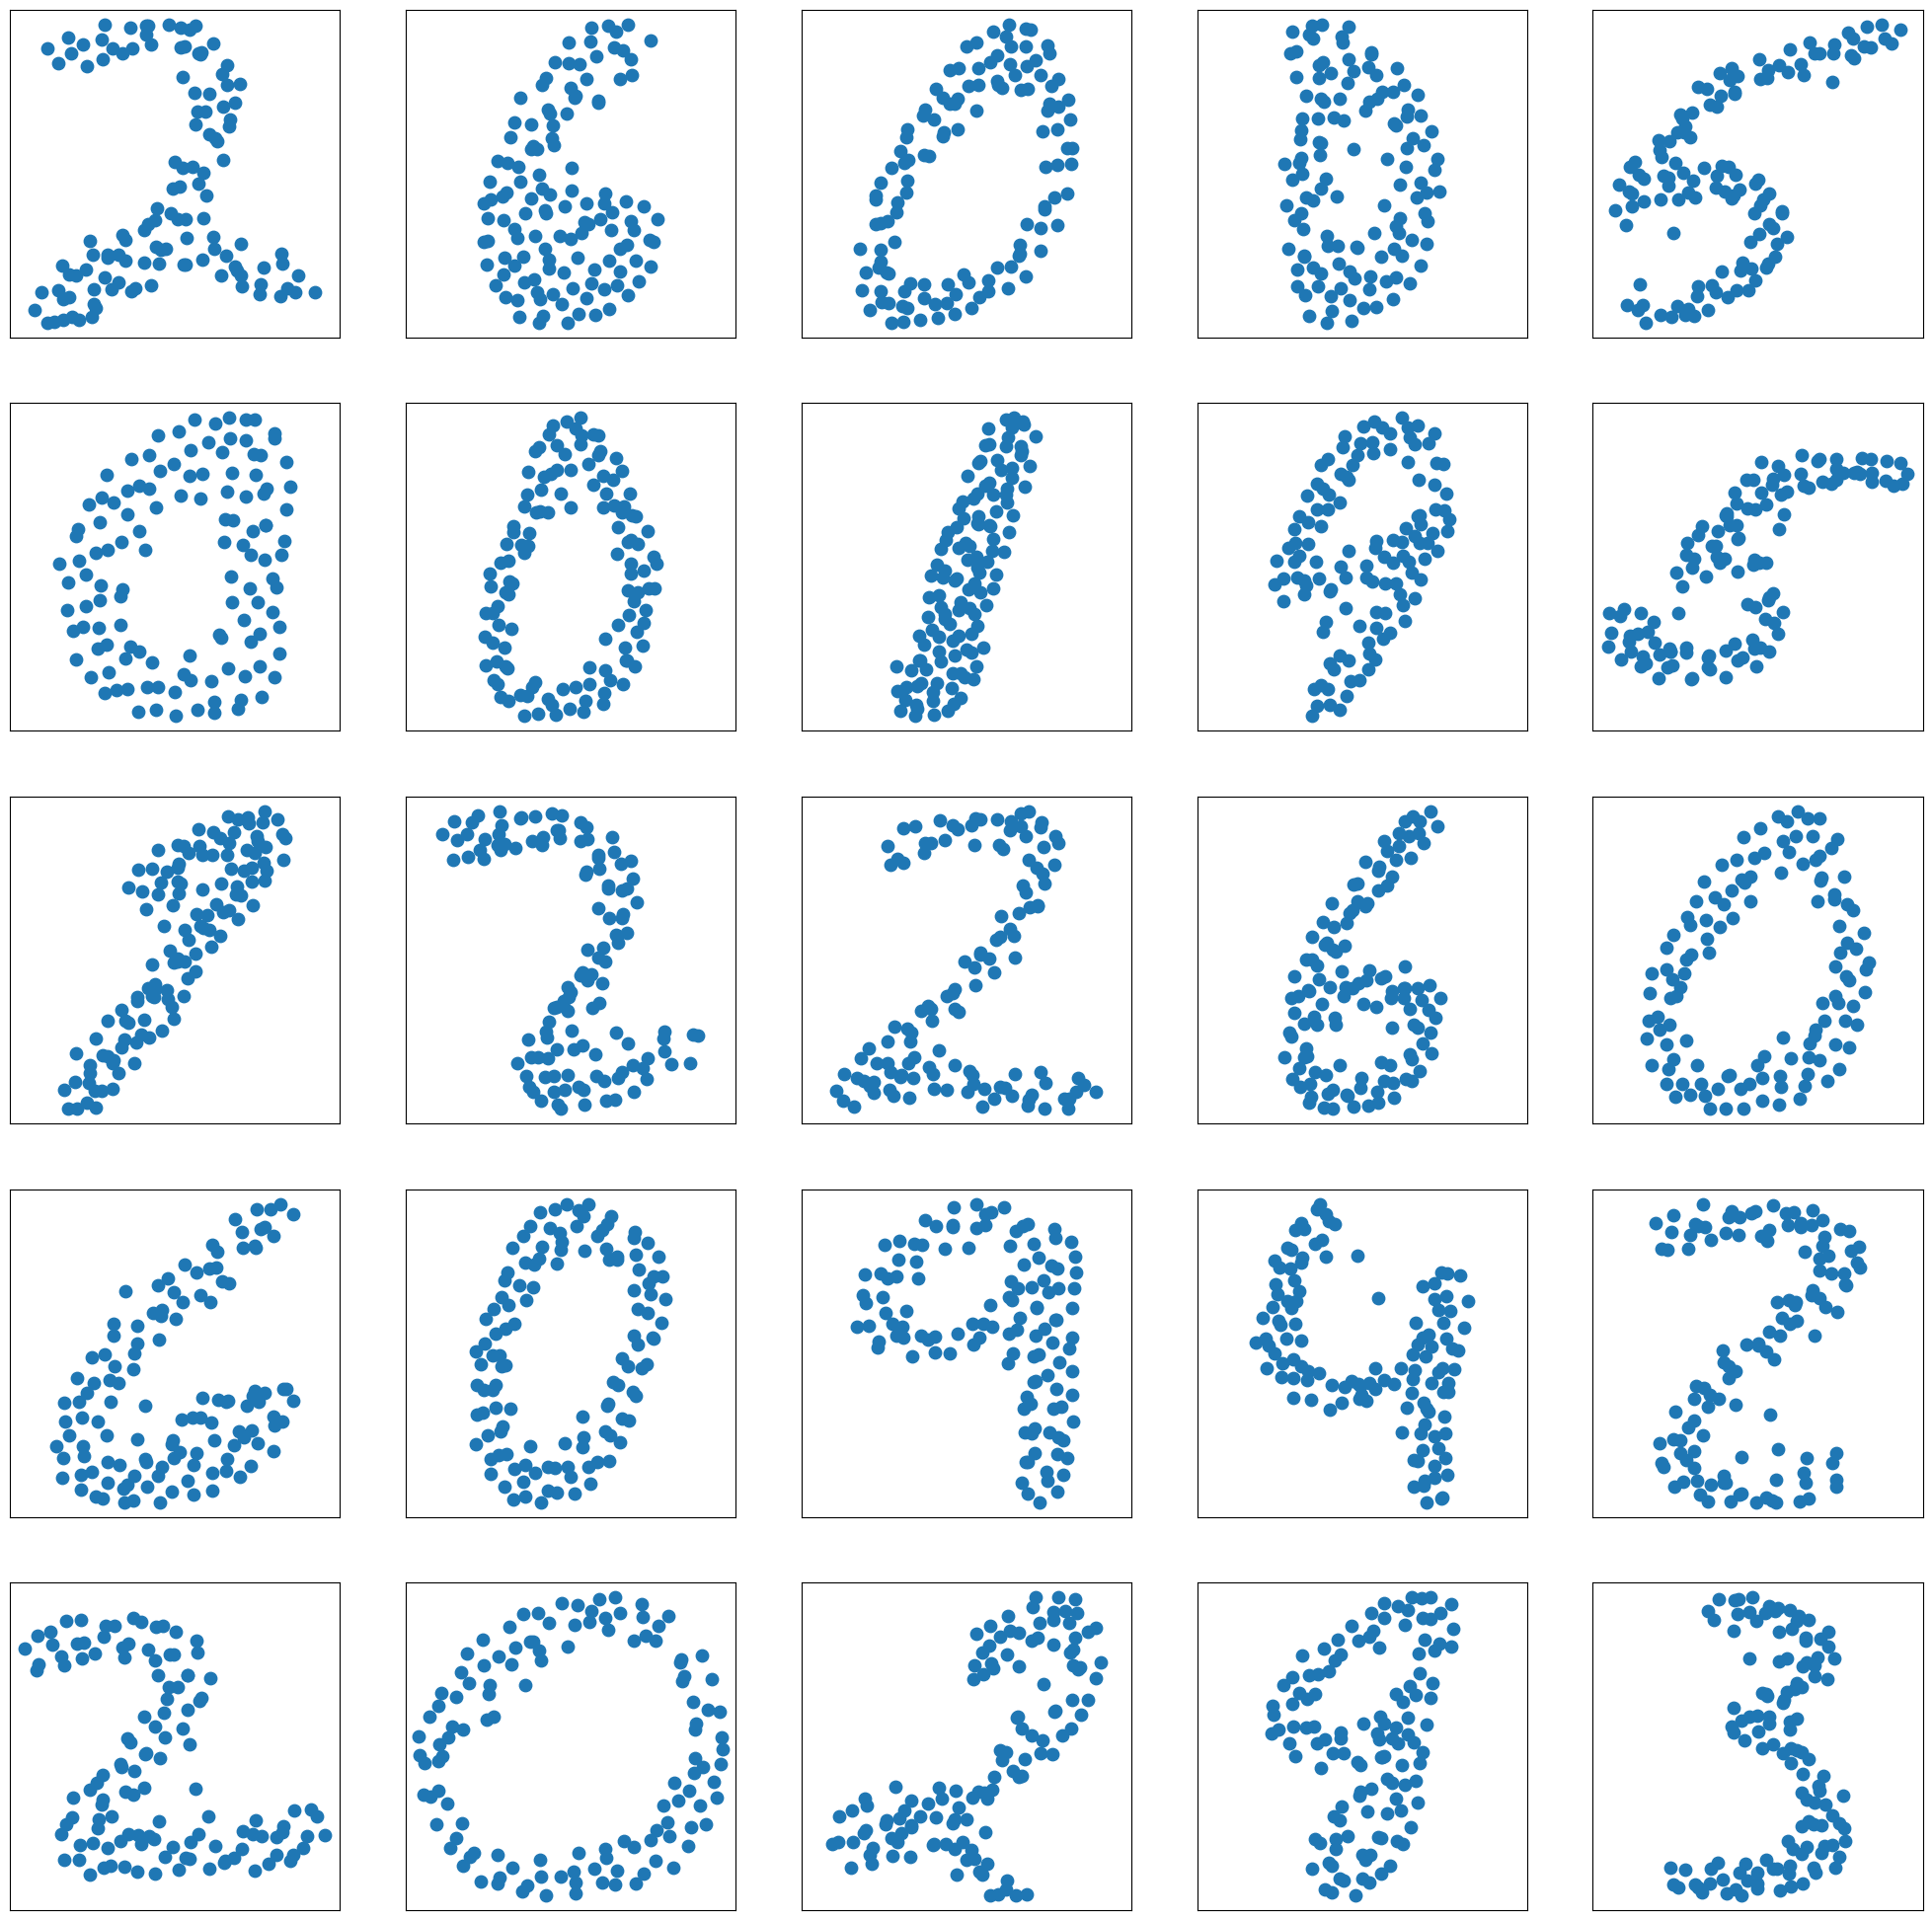

In [20]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(train_decodings)))
    
    plt.subplot(5,5,1+_)
    plt.scatter(train_decodings[ind][:, 1], -train_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

### Plot test

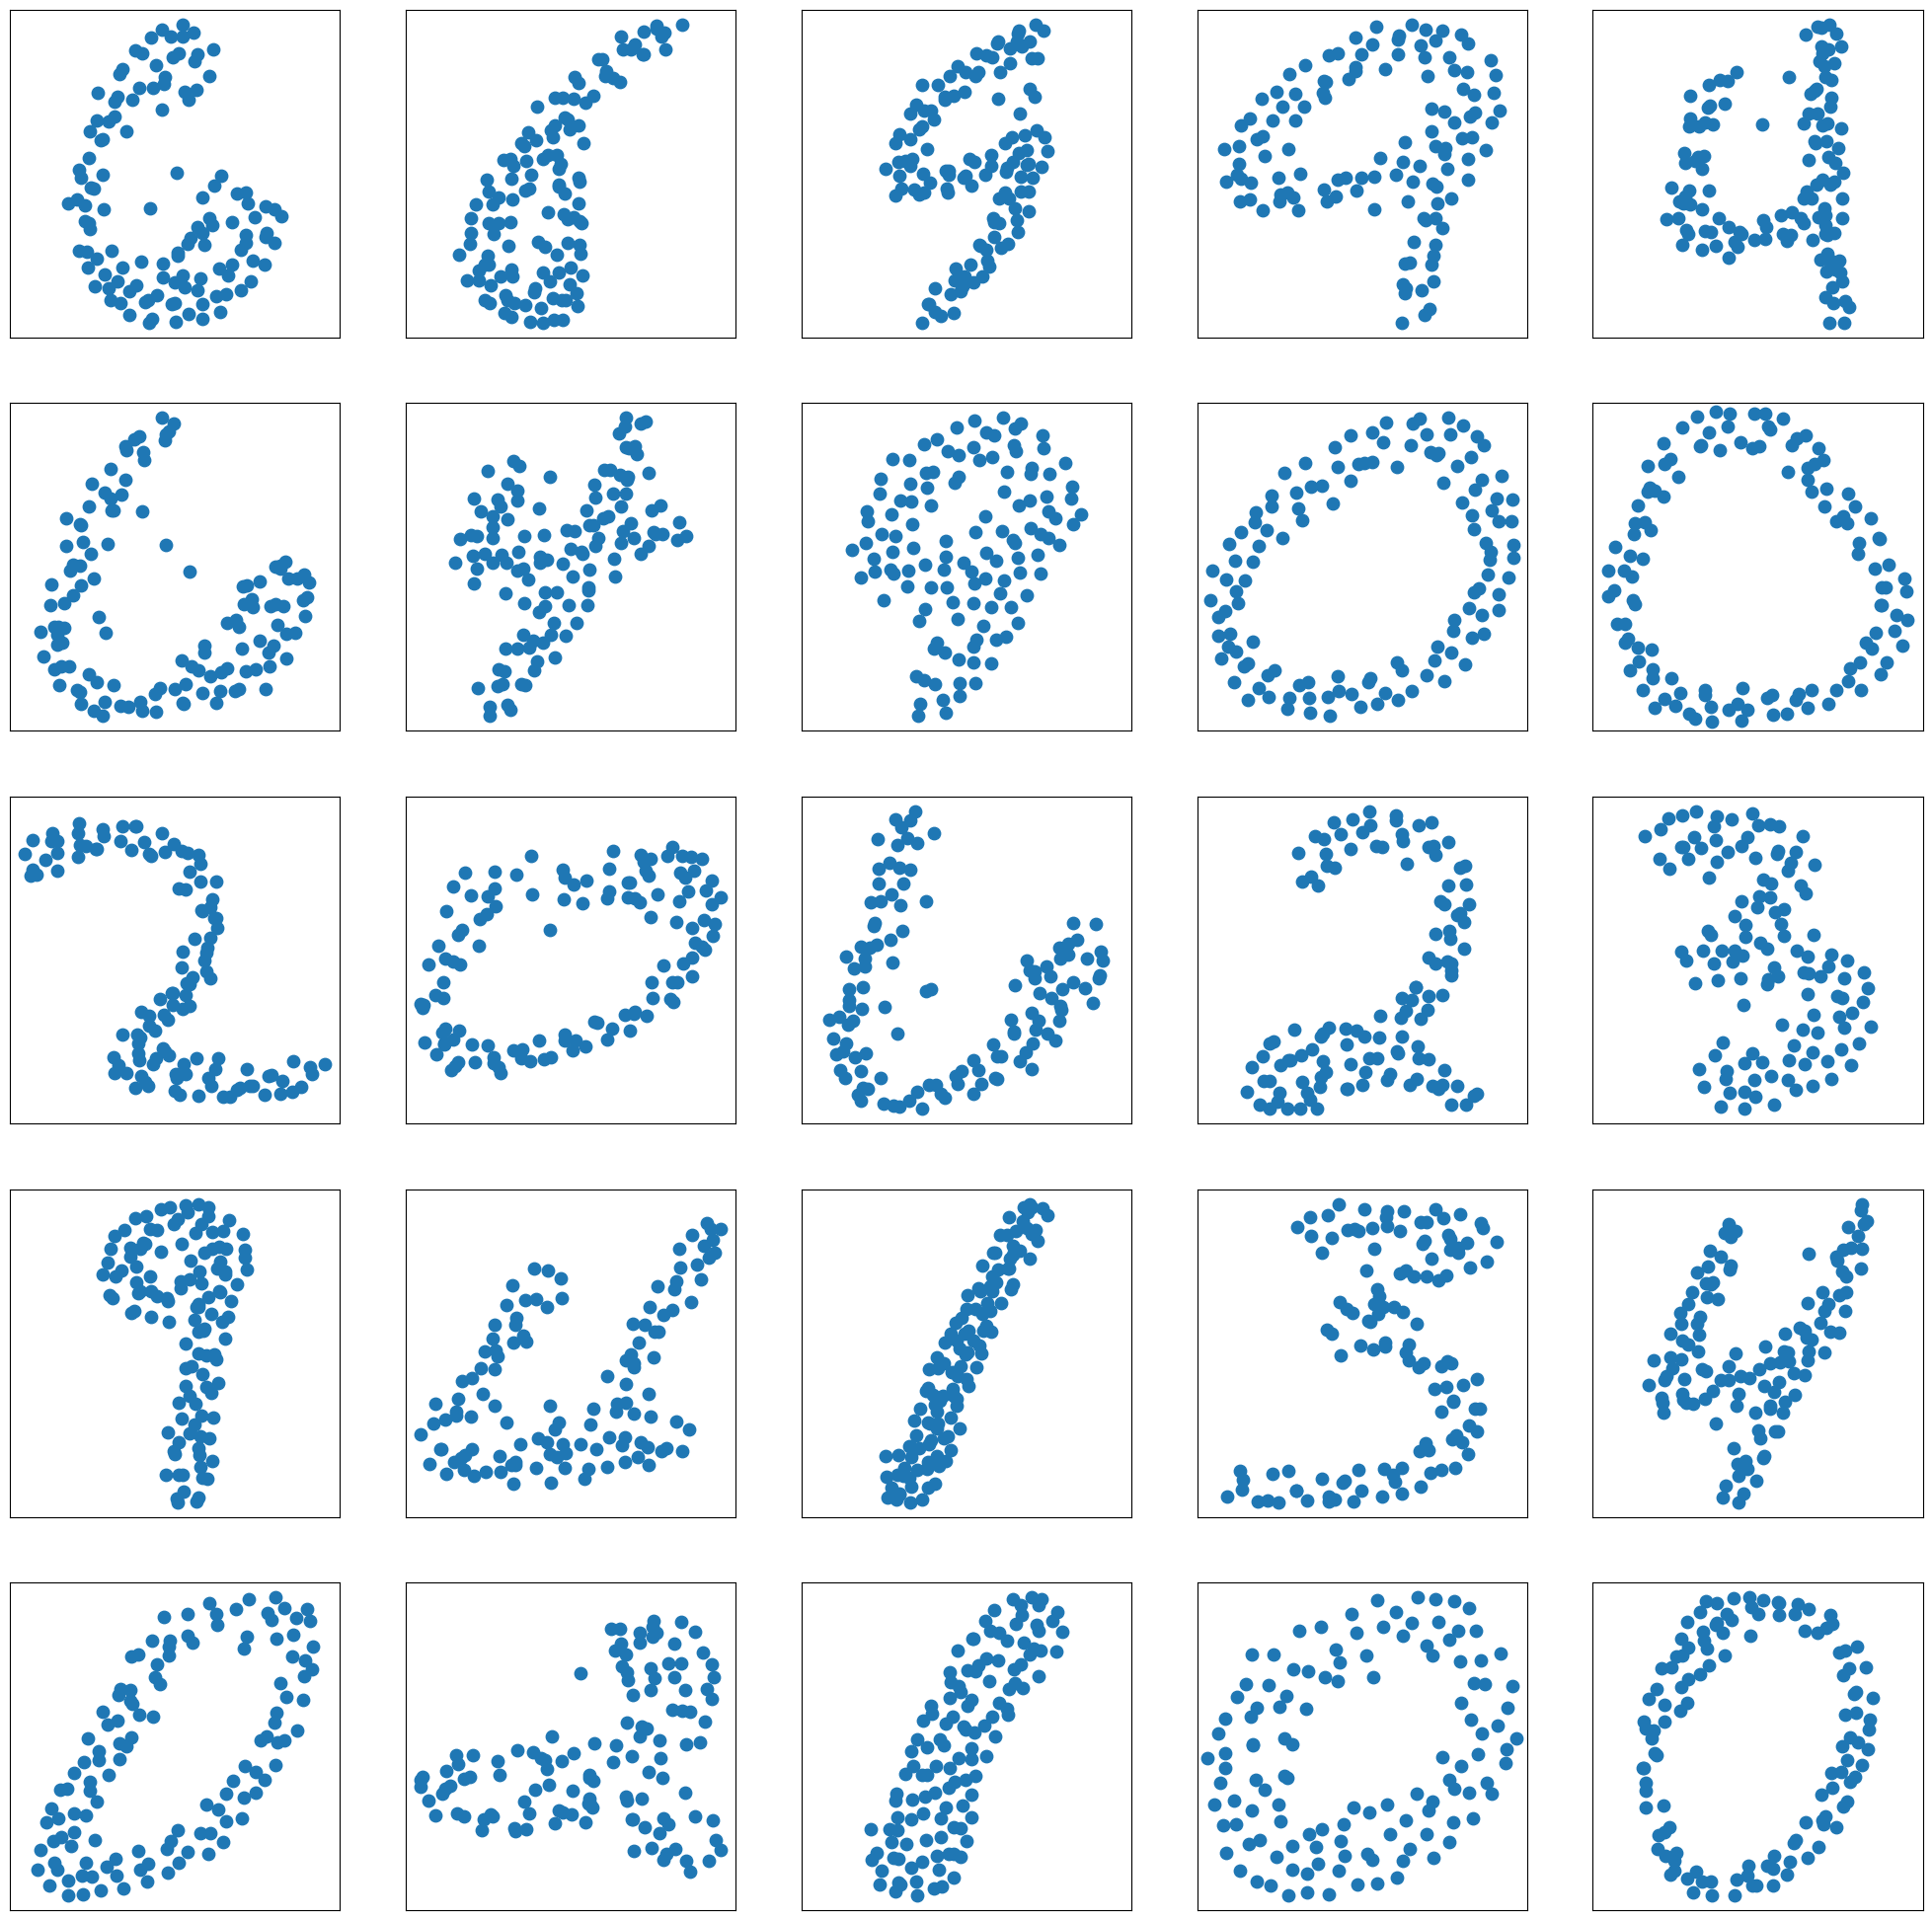

In [21]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(test_decodings)))
    
    plt.subplot(5,5,1+_)
    plt.scatter(test_decodings[ind][:, 1], -test_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

### Barycenters

#### Calculate per-class encoding mean

In [22]:
class_encoding_mean = np.asarray([np.mean(train_encodings[label_train == digit], axis = 0) for digit in list(set(label_train))])

#### Decode for Wasserstein barycenters

In [23]:
class_barycenters = WormholeModel.decode(class_encoding_mean)

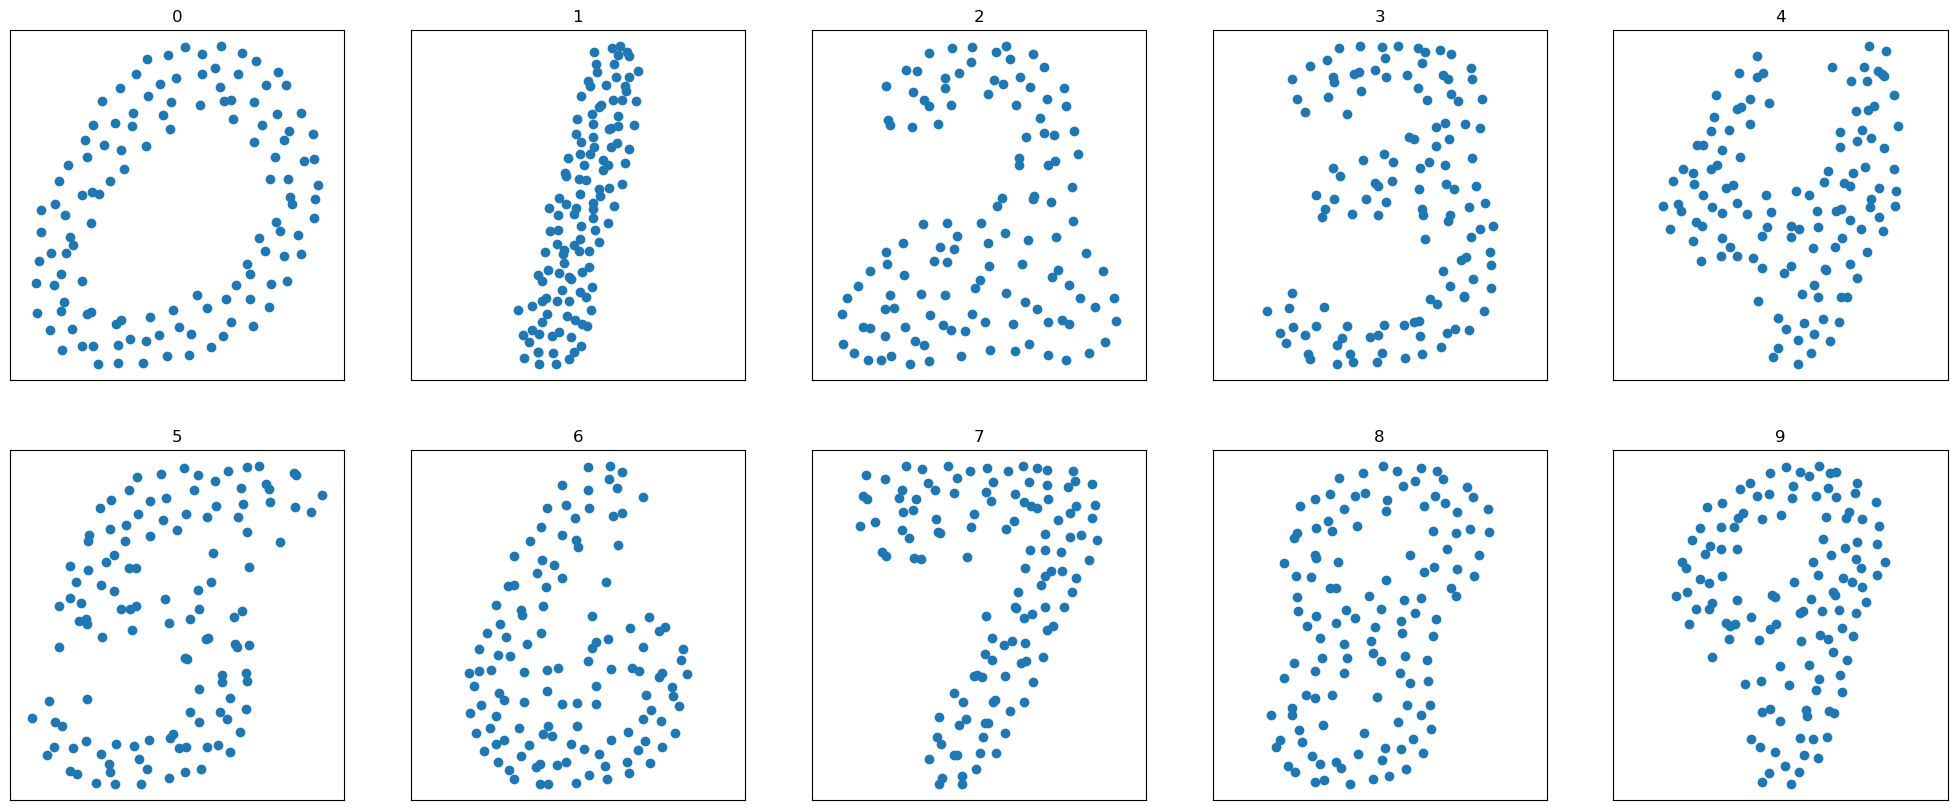

In [24]:
fig = plt.figure(figsize=(25, 10))
for i in list(set(label_train)):
    
    plt.subplot(2,5,1+i)
    plt.scatter(class_barycenters[i][:, 1], -class_barycenters[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
plt.show()


### Point Cloud Interpolation

#### Chooce start and end encodings

In [25]:
start_ind = np.random.randint(train_encodings.shape[0])
end_ind = np.random.randint(train_encodings.shape[0])

start_enc = train_encodings[start_ind]
end_enc = train_encodings[end_ind]


#### Linearly interpolate between them

In [26]:
interpolated_encodings = np.linspace(start_enc, end_enc, 8)

#### Decode interpolations

In [27]:
interpolated_decodings = WormholeModel.decode(interpolated_encodings)

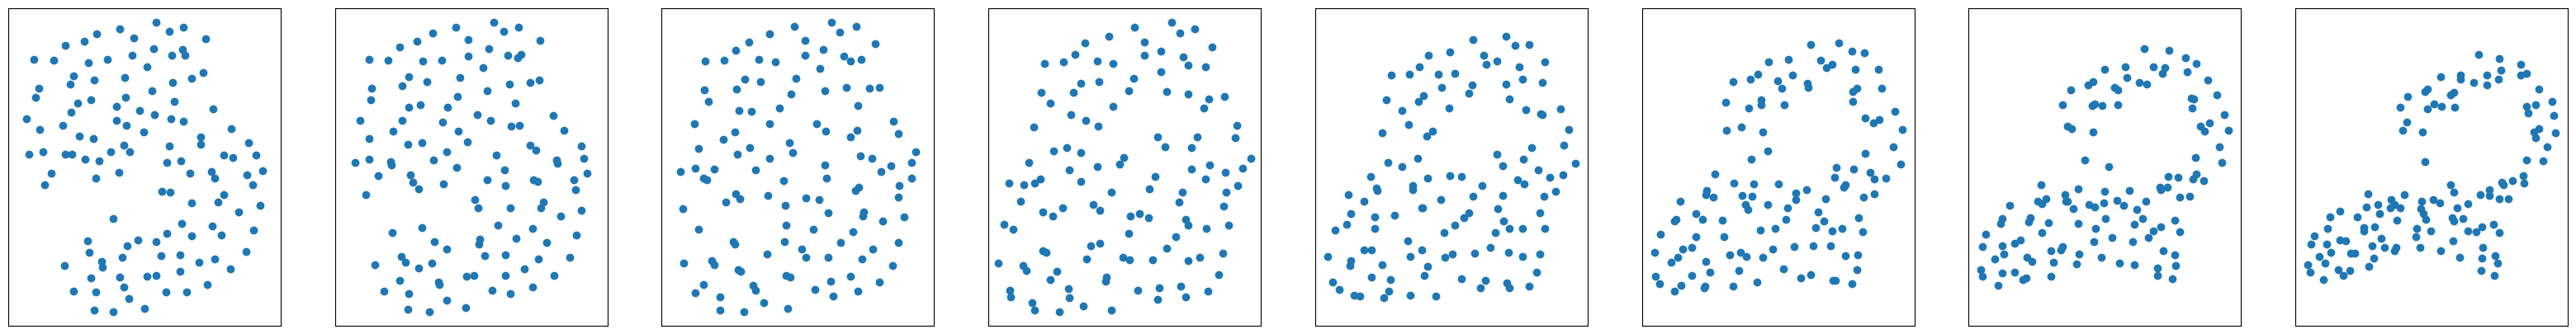

In [28]:
fig = plt.figure(figsize=(interpolated_decodings.shape[0]*5, 5))

    
for i in range(interpolated_decodings.shape[0]):
    
    plt.subplot(1,interpolated_decodings.shape[0],1+i)
    plt.scatter(interpolated_decodings[i][:, 1], -interpolated_decodings[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Draw UMAPs

In [29]:
fit = umap.UMAP(
    n_neighbors = 30,
    min_dist = 0.01,
    n_components = 2,
)

umap = fit.fit_transform(np.concatenate([train_encodings, test_encodings], axis = 0))
umap_train =  umap[:train_encodings.shape[0]] 
umap_test =  umap[train_encodings.shape[0]:] 

In [30]:
cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')
label_palette = {ctype:cat_cmap(i) for i,ctype in enumerate(list(set(label_train)))}

/scratch/lsftmp/5659470.tmpdir/ipykernel_63395/2627742441.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')


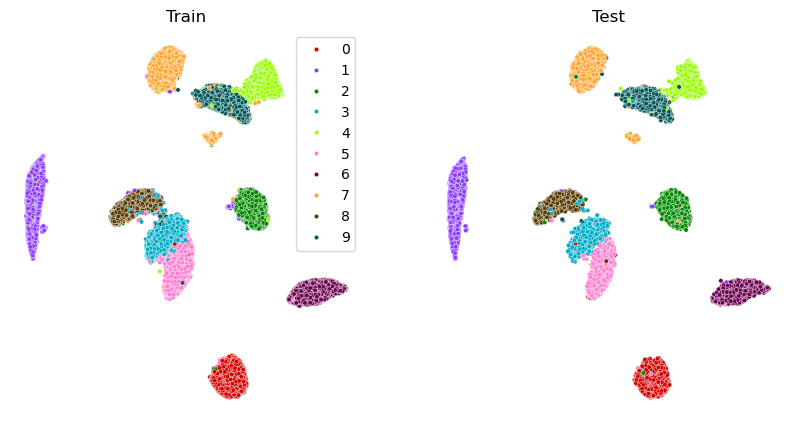

In [31]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x = umap_train[:, 0], 
                y = umap_train[:, 1], legend = True,
                hue = label_train, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Train")

plt.subplot(122 )
sns.scatterplot(x = umap_test[:, 0], 
                y = umap_test[:, 1], legend = False,
                hue = label_test, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Test")
plt.show()

## Classify Digits

In [32]:
classifier = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(train_encodings, label_train)
test_predictions = classifier.predict(test_encodings)

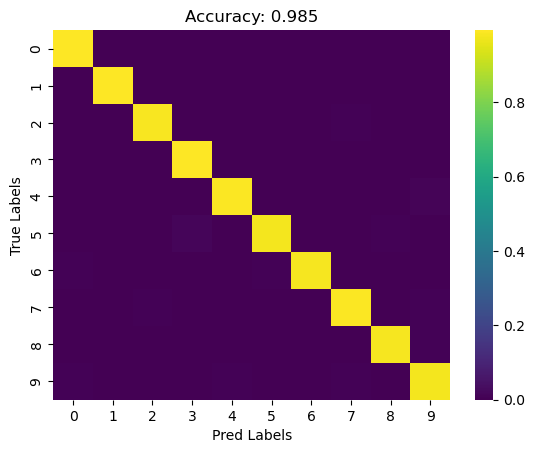

In [33]:
cm = pd.DataFrame(sklearn.metrics.confusion_matrix(label_test, test_predictions, labels=classifier.classes_, normalize = 'true'),
                  index = classifier.classes_, columns = classifier.classes_,)
sns.heatmap(cm, cmap = 'viridis')
plt.ylabel("True Labels")
plt.xlabel("Pred Labels")
plt.title("Accuracy: " + str(round(np.mean(label_test == test_predictions), 3)))
plt.show()